In [1]:
import json
import argparse
import code
from pprint import pprint
from termcolor import colored
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, Counter

import numpy as np
from typing import Dict, Any
from tqdm.auto import tqdm

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stopWords = set(stopwords.words('english'))

In [2]:
code_file = '../../raw-datasets/django/all.code'
anno_file = '../../raw-datasets/django/all.anno'

In [18]:
code_lines = [l.strip() for l in open(code_file, "rt").readlines()]
anno_lines = [l.strip() for l in open(anno_file, "rt").readlines()]

print(len(code_lines))

assert len(code_lines) == len(anno_lines)

example = namedtuple("Example", ["code", "label"])

data = list(map(lambda x : example(*x), zip(code_lines, anno_lines)))

18805


In [37]:
for i in range(len(data)):
    if 'constant_re' in data[i].code:
        print(data[i].label)
        print(data[i].code)
        print("---")
        

call the function re.compile with an argument raw string "_\(((?:".*?")|(?:'.*?'))\)", substitute the result for constant_re.
constant_re = re . compile ( r"""_\(((?:".*?")|(?:'.*?'))\)""" )
---
call the function constant_re.findall with an argument t.contents, substitute the result for cmatches.
cmatches = constant_re . findall ( t . contents )
---
call the method constant_re.findall with an argument t.contents, for every fmatch in the result,
for fmatch in constant_re . findall ( t . contents ) :
---
call the method constant_re.match with first element of parts as an argument, substitute the result for cmatch.
cmatch = constant_re . match ( parts [ 0 ] )
---


### Vocabulary

In [5]:
PUNCTUATION = {
    'sep'   : u'\u200b' + "/-'´′‘…—−–",
    'keep'  : "&",
    'remove': '?!.,，"#$%\'()*+-/:;<=>@[\\]^_`{|}~“”’™•°'
}

def clean_text(x):
    x = x.lower()

    for p in PUNCTUATION['sep']:
        x = x.replace(p, " ")
    for p in PUNCTUATION['keep']:
        x = x.replace(p, " %s " % p)
    for p in PUNCTUATION['remove']:
        x = x.replace(p, "")

    return x

In [6]:
# random.sample(anno_lines, 1)[0].split()

tokenizer = RegexpTokenizer(r'\w+')

anno_vocab = Counter()

for a in tqdm(anno_lines):
    for w in filter(lambda x : x not in stopWords, tokenizer.tokenize(a)):
        anno_vocab[w.lower()] += 1

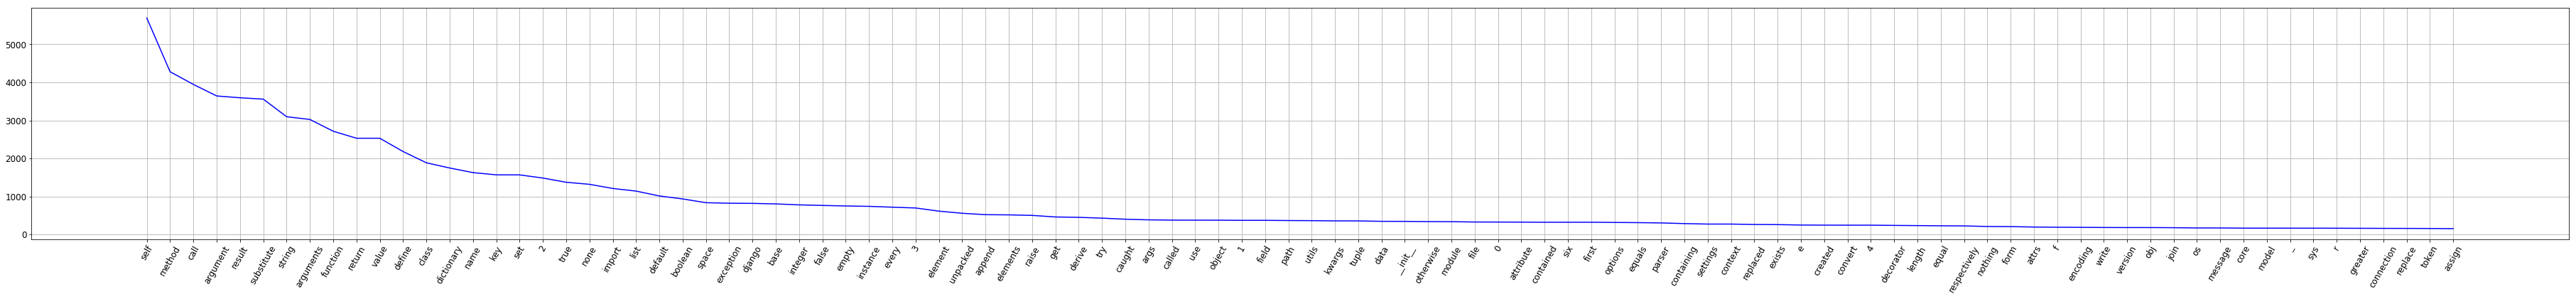

In [7]:
n = 100
words, counts = zip(*anno_vocab.most_common(n))

plt.figure(figsize=(int(0.64 * n),6))
plt.xticks(range(len(words)), words, rotation=60, fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('symlog')
plt.plot(range(len(words)), counts, 'b-')
plt.grid()
plt.show()

## Vocabulary coverage

In [8]:
listing = [l.strip() for l in open('../data-out/python-3.7.3-docs-text/all_files_listing.txt').readlines()]
all_words = Counter()

for l in tqdm(listing, desc="Get all words"):
    file_contents = [clean_text(l.strip().lower()) for l in open(l, "rt").readlines()]
    
    for line in file_contents:
        for w in line.split():
            if re.match(r'[\w]+', w) and w not in stopWords:
                all_words[w] += 1

In [29]:
def get_vocab_coverage(data, vocab) -> (Counter, Counter):
    """
    How much of 'data' is in 'vocab'
    """
    
    oov = Counter() # out-of-vocab
    inv = Counter() # in-vocab
    oov_uniq_num = inv_uniq_num = 0.0
    oov_all_num = inv_all_num = 0.0
    
    for w in tqdm(data):
        if w in vocab:
            inv[w] = data[w]
            inv_uniq_num += 1
            inv_all_num += data[w]
        else:
            oov[w] = data[w]
            oov_uniq_num += 1
            oov_all_num += data[w]
    
    
    assert inv_all_num + oov_all_num == sum(data.values())
    
    cov_uniq = 100.0 * round(inv_uniq_num / len(data), 5)
    cov_all = 100.0 * round(inv_all_num / (inv_all_num + oov_all_num), 5)
    
    print("coverage (unique): %.3f%%" % cov_uniq)
    print("coverage (all text): %.3f%%" % cov_all)
    
    return oov, inv


oov, inv = get_vocab_coverage(anno_vocab, all_words)


coverage (unique): 38.994%
coverage (all text): 85.667%


In [11]:
'assign' in all_words

True